In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from torch.distributions import MultivariateNormal
from shapely.geometry import Polygon, Point, LineString
import matplotlib

In [2]:
plt.rc('font', size=14)          # controls default text sizes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, u_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        self.u_dim = u_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)

        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_4 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_5 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_6 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.layerout = nn.Linear(self.hidden_dim, self.u_dim, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=1)

        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.layer_2(h_temp)
        h = self.activation(h_temp + h) 

        h_temp = self.activation(self.layer_3(h))
        h_temp = self.layer_4(h_temp)
        h = self.activation(h_temp + h)

        h_temp = self.activation(self.layer_5(h))
        h_temp = self.layer_6(h_temp)
        h = self.activation(h_temp + h)
        
        z_out = self.layerout(h) 
        return z_out

In [4]:
class Obstacle():
    def __init__(self, boundary):
        self.boundary = Polygon(boundary)
        
    
    def trajectory_intersects(self, trajectory):
        """
        Check if a trajectory intersects with the obstacle.
        """
        traj_line = LineString(trajectory)  
        return self.boundary.intersects(traj_line)  

    def plot(self, ax=None, color='r', alpha=0.5):
        """
        Plot the obstacle on a matplotlib figure.
        
        :param ax: Optional matplotlib axis to plot on.
        :param color: Color of the obstacle.
        :param alpha: Transparency of the obstacle.
        """
        if ax is None:
            fig, ax = plt.subplots()

        x, y = self.boundary.exterior.xy  
        ax.fill(x, y, color=color, alpha=alpha)
        ax.plot(x, y, 'k-', linewidth=1)

class Triangle(Obstacle):
    def __init__(self, center, size):
        """
        Initialize a triangular obstacle.
        
        :param center: (x, y) center of the triangle.
        :param size: Distance from the center to the vertices.
        """
        x, y = center
        boundary = [
            (x, y + size),  # Top vertex
            (x - size, y - size),  # Bottom left
            (x + size, y - size),  # Bottom right
        ]
        super().__init__(boundary)


# Child class for Circle Obstacle
class Circle(Obstacle):
    def __init__(self, center, radius, num_points=500):
        """
        Initialize a circular obstacle.
        
        :param center: (x, y) center of the circle.
        :param radius: Radius of the circle.
        :param num_points: Number of points to approximate the circle.
        """
        x, y = center
        boundary = [(x + radius * np.cos(theta), y + radius * np.sin(theta)) 
                    for theta in np.linspace(0, 2 * np.pi, num_points)]
        super().__init__(boundary)


# Child class for Rectangle Obstacle
class Rectangle(Obstacle):
    def __init__(self, bottom_left, width, height):
        """
        Initialize a rectangular obstacle.
        
        :param bottom_left: (x, y) coordinates of the bottom-left corner.
        :param width: Width of the rectangle.
        :param height: Height of the rectangle.
        """
        x, y = bottom_left
        boundary = [
            (x, y),  # Bottom-left
            (x + width, y),  # Bottom-right
            (x + width, y + height),  # Top-right
            (x, y + height)  # Top-left
        ]
        super().__init__(boundary)

In [5]:
N = 4000 # number of samples
T = 1000  # number of time steps
n = 2 # system dimension
m = 2 # control dimension

tf = 1.0 # time horizon
# dt = tf/T # time step

n_sigma = 0.3 # noise level

A = torch.tensor([[0.0, 0.0],[0.0, 0.0]])
# B = torch.tensor([[0.0],[1.0]])
B = torch.eye(2)

In [6]:
x_0 = torch.tensor([[0.0],[0.0]])
y = torch.tensor([[2.0],[2.0]])

In [7]:
t = torch.linspace(0,tf,T).reshape(-1,1) ## time grid shape (T,1)

In [8]:
dt = t[1] - t[0]
dt

tensor([0.0010])

In [9]:
def generate_phit(t, n):
    """
    t shape is (T, 1), output shape is (T, n, n)
    """
    T, _ = t.shape
    phi_t = torch.zeros((T, n, n))
    phi_t[:,0,0] = t[:,0]
    phi_t[:,0,1] = torch.zeros_like(t[:,0])
    phi_t[:,1,0] = torch.zeros_like(t[:,0])
    phi_t[:,1,1] = t[:,0]
    return phi_t

In [10]:
def generate_expAt(A, t):
    """
    A shape is (n,n), t shape is (T,1), output shape is (T,n,n)
    """
    T, _ = t.shape
    A_rep = A.repeat(T,1,1)
    A_t = A_rep * t.unsqueeze(-1)
    A_t_exp = torch.matrix_exp(A_t)

    return A_t_exp

In [ ]:
exp1tAtrans = generate_expAt(A.T, tf-t)
expA = generate_expAt(A, torch.ones_like(t))[0,:,:]
phi_1 = generate_phit(torch.ones_like(t), n)

U_d = torch.einsum('tij,tjk->tik', torch.einsum('ij,tjk->tik', B.T, exp1tAtrans), torch.linalg.pinv(phi_1)) @ (y - expA @ x_0).squeeze(-1)

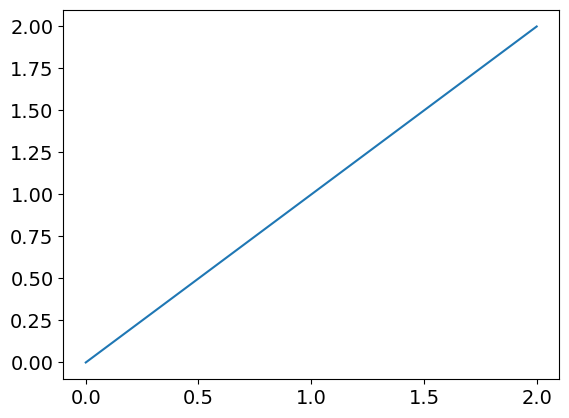

In [12]:
dt = t[1] - t[0]
X_forward = torch.zeros((T, n))
X_forward[0,:] = x_0.squeeze(-1)
for i in range(1, T):
    # print(i)
    X_forward[i,:] = (A @ X_forward[i-1,:] + B @ U_d[i-1,:]) * dt + X_forward[i-1,:]

plt.figure()
plt.plot(X_forward[:,0], X_forward[:,1])
plt.show()

In [1]:
### Generate backward data
X_backward = torch.zeros((T, N, n))
X_backward[-1,:,:] = torch.randn(N,n)*0.0 + y.T
for i in range(T-1, 0, -1):
    # print(i)
    dX = (A @ X_backward[i,:,:].T  + B @ U_d[i-1,:].repeat(N,1).T).T * dt + (B @ (n_sigma * torch.randn(N,m)*np.sqrt(dt)).T).T
    X_backward[i-1,:,:] = X_backward[i,:,:] - dX

NameError: name 'torch' is not defined

In [14]:
X_backward.dtype

torch.float32

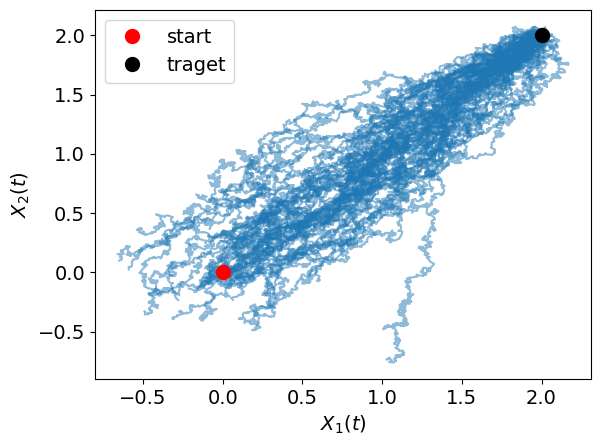

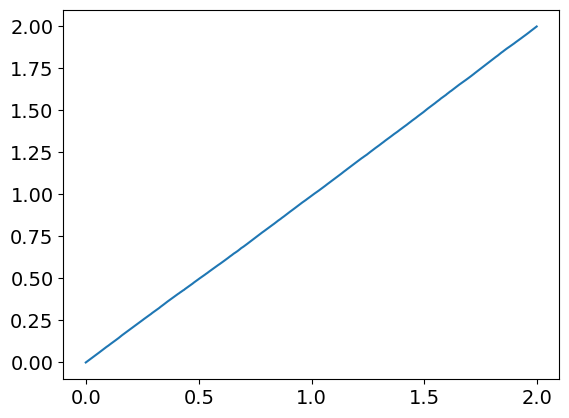

In [15]:
plt.figure()
for i in range(50):
    plt.plot(X_backward[:,i,0], X_backward[:,i,1], color='C0', alpha=0.5)
plt.plot(x_0[0], x_0[1], color='r', marker='o', markersize=10, label='start', ls='None')
plt.plot(y[0], y[1], color='black', marker='o', markersize=10, label='traget', ls='None')
plt.xlabel(r'$X_1(t)$')
plt.ylabel(r'$X_2(t)$')
plt.legend()
plt.show()

plt.figure()
plt.plot(X_backward[:,:,0].mean(axis=1), X_backward[:,:,1].mean(axis=1))
plt.show()

In [16]:
def jacobian(y: torch.Tensor, x: torch.Tensor, device, need_higher_grad=True) -> torch.Tensor:
    (Jac,) = torch.autograd.grad(
        outputs=(y.flatten(),),
        inputs=(x,),
        grad_outputs=(torch.eye(torch.numel(y)).to(device),),
        create_graph=need_higher_grad,
        allow_unused=True,
        is_grads_batched=True
    )
    if Jac is None:
        Jac = torch.zeros(size=(y.shape + x.shape))
    else:
        Jac.reshape(shape=(y.shape + x.shape))
    return Jac

In [17]:
def batched_jacobian(batched_y:torch.Tensor,batched_x:torch.Tensor,device, need_higher_grad = True) -> torch.Tensor:
    sumed_y = batched_y.sum(dim = 0) # y_shape
    J = jacobian(sumed_y,batched_x,device, need_higher_grad) # y_shape x N x x_shape
    
    dims = list(range(J.dim()))
    dims[0],dims[sumed_y.dim()] = dims[sumed_y.dim()],dims[0]
    J = J.permute(dims = dims) # N x y_shape x x_shape
    return J

In [18]:
device = torch.device('cpu')

In [19]:
x = torch.tensor([[1.0],[2.0]], requires_grad=True).to(device)
y = torch.stack((x[0]**2 + x[1]**2, x[0]*x[1])).to(device)
jac = jacobian(y, x, device)
jac[:,:,0]

tensor([[2., 4.],
        [2., 1.]], grad_fn=<SelectBackward0>)

In [20]:
x = torch.tensor([[1.0,2.0],[3.0,4.0],[5.0,6.0],[7.0,8.0],[9.0,10.0]], requires_grad=True).to(device)
y = torch.stack((x[:,0]**2 + x[:,1]**2, x[:,0]*x[:,1]),dim=1).to(device)
Bjac = batched_jacobian(y, x, device)
Bjac

tensor([[[ 2.,  4.],
         [ 2.,  1.]],

        [[ 6.,  8.],
         [ 4.,  3.]],

        [[10., 12.],
         [ 6.,  5.]],

        [[14., 16.],
         [ 8.,  7.]],

        [[18., 20.],
         [10.,  9.]]], grad_fn=<PermuteBackward0>)

In [21]:
B = B.to(device)
temp_test = torch.einsum('ij,tjk->tik', B@B.T, Bjac)
BatchTrace_test = temp_test.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
BatchTrace_test

tensor([[ 3.],
        [ 9.],
        [15.],
        [21.],
        [27.]], grad_fn=<SumBackward1>)

In [22]:
# device = torch.device("mps")
# # device = torch.device("cpu")
print(device)

cpu


In [23]:
### learning k(x,t)###
t_N = t.repeat(1,N).reshape(T,N,1).to(device)
X_backward = X_backward.to(device)
ITERS = 25000
BATCH_SIZE = 32
LR = 1e-4

B = B.to(device)
k = score_nn(n, m, 32).to(device)
# init_weights(f)
k.train()
optimizer_k = torch.optim.Adam(k.parameters(), lr=LR)
scheduler_k = torch.optim.lr_scheduler.StepLR(optimizer_k, step_size=500, gamma=0.9)

losses = []
for i in range(ITERS):
    # print(i)
    idx = torch.randperm(N)[:BATCH_SIZE].to(device)
    X_train = X_backward[:,idx,:]
    X_train = X_train.view(-1, n)
    t_train = t_N[:,idx,:]  
    t_train = t_train.view(-1, 1)
    X_train.requires_grad = True
    k_value = k.forward(X_train, t_train) 
    # print(k_value.shape)
    gk = k_value @ B.T # shape (T*B, n)
    # gk = gk.unsqueeze(1) # shape (T*B, 1, n)
    batch_norm = torch.einsum('tij,tjk->tik', gk.unsqueeze(1), gk.unsqueeze(2)).squeeze(-1) # shape (T*B,1)
    # loss = score_norm

    batch_jac = batched_jacobian(gk, X_train,device)
    temp = torch.einsum('ij,tjk->tik', B@B.T, batch_jac)
    batch_trace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
    loss = (0.5*batch_norm + batch_trace).sum()/BATCH_SIZE/T
    

    optimizer_k.zero_grad()
    loss.backward()
    optimizer_k.step()
    scheduler_k.step()
    
    if  (i+1)==ITERS or (i+1)%1000==0:
        k_value = k.forward(X_train, t_train) 
        gk = k_value @ B.T
        score_norm = torch.sum(gk**2)/BATCH_SIZE/T
        loss = score_norm
        
        BatchJac = batched_jacobian(gk, X_train,device)
        temp = torch.einsum('ij,tjk->tik', B@B.T, BatchJac)
        BatchTrace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
        loss = loss*0.5 + BatchTrace.sum()/BATCH_SIZE/T
        losses.append(loss.item())

        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 1000/25000, loss = -21.282119750977
Iteration: 2000/25000, loss = -34.483806610107
Iteration: 3000/25000, loss = -40.000637054443
Iteration: 4000/25000, loss = -43.954475402832
Iteration: 5000/25000, loss = -39.309600830078
Iteration: 6000/25000, loss = -54.407726287842
Iteration: 7000/25000, loss = -53.356472015381
Iteration: 8000/25000, loss = -56.938529968262
Iteration: 9000/25000, loss = -43.725811004639
Iteration: 10000/25000, loss = -60.286029815674
Iteration: 11000/25000, loss = -57.661670684814
Iteration: 12000/25000, loss = -57.391990661621
Iteration: 13000/25000, loss = -61.645286560059
Iteration: 14000/25000, loss = -54.426921844482
Iteration: 15000/25000, loss = -57.543144226074
Iteration: 16000/25000, loss = -51.183174133301
Iteration: 17000/25000, loss = -60.868637084961
Iteration: 18000/25000, loss = -53.287551879883
Iteration: 19000/25000, loss = -57.867973327637
Iteration: 20000/25000, loss = -64.866889953613
Iteration: 21000/25000, loss = -62.244644165039
I

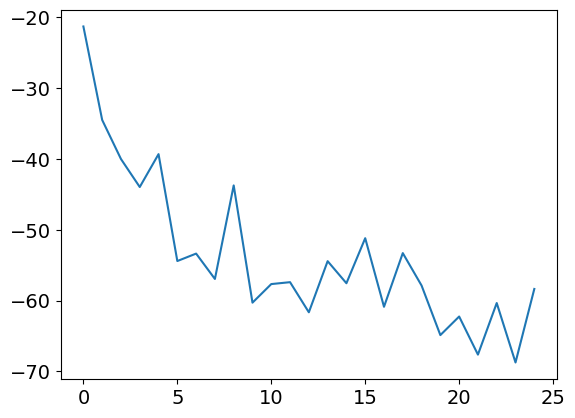

In [24]:
plt.figure()
plt.plot(losses)
plt.show()


In [25]:
exp1tAtrans = generate_expAt(A.T, 1-t)
phi1t = generate_phit(1-t, n)
exp1tA = generate_expAt(A, 1-t)
expt1A = generate_expAt(A, t-1)


In [26]:
y = torch.tensor([[2.0],[2.0]])

In [27]:
W_forward = torch.zeros((T, N, m))
for i in range(T):
    W_forward[i,:,:] = torch.randn(N,m)*np.sqrt(dt)

W_forward = W_forward.to(device)

In [28]:
test_scalar = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
k_record = torch.zeros((T, N, m))
u_s_record = torch.zeros((T, N, m))
u1_record = torch.zeros((T, N, m))
u2_record = torch.zeros((T, N, m))
u3_record = torch.zeros((T, N, m))
X_pred = torch.zeros((T, N, n))
X_pred[0,:,:] = torch.zeros((N,n))
# X_pred[0,:,:] = torch.randn(N,n)*0.2
X_pred2 = torch.zeros((T, N, n))
X_pred2[0,:,:] = torch.zeros((N,n))
X_pred3 = torch.zeros((T, N, n))
X_pred3[0,:,:] = torch.zeros((N,n))
X_test = torch.zeros((len(test_scalar), T, N, n)).to(device)
k.eval()
A = A.to(device)
dt = dt.to(device)
# inf_device = torch.device("cpu")
# k.to(inf_device)
# B = B.to(inf_device)
for i in range(1, T):
    for j in range(len(test_scalar)):
        alpha = test_scalar[j]
        k_value = k.forward(X_test[j,i-1,:,:], t[i-1].repeat(N,1).to(device))
        u = U_d[i-1,:].repeat(N,1).to(device) + alpha * k_value *n_sigma**2
        dX = (A @ X_test[j,i-1,:,:].T  + B @ u.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
        X_test[j,i,:,:] = X_test[j,i-1,:,:] + dX
        
for i in range(1, T):

    ## NN method
    k_value = k.forward(X_pred[i-1,:,:], t[i-1].repeat(N,1).to(device))
    k_record[i,:,:] = k_value*n_sigma**2
    u = U_d[i-1,:].repeat(N,1) + k_value*n_sigma**2
    u1_record[i-1,:,:] = u
    dX = (A @ X_pred[i-1,:,:].T  + B @ u.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred[i,:,:] = X_pred[i-1,:,:] + dX

    ## u deterministic + u stochastic method
    # u_s_record[i,:,:] = -(X_pred2[i-1,:,:] - X_forward[i-1,:])@ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    u2 = U_d[i-1,:].repeat(N,1) 
    u2_record[i-1,:,:] = u2
    dX2 = (A @ X_pred2[i-1,:,:].T  + B @ u2.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred2[i,:,:] = X_pred2[i-1,:,:] + dX2
    
    ## u feedback method
    u3 = -(X_pred3[i-1,:,:] - (expt1A[i-1,:,:] @ y).repeat(1,N).T) @ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    u3_record[i-1,:,:] = u3
    dX3 = (A @ X_pred3[i-1,:,:].T  + B @ u3.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred3[i,:,:] = X_pred3[i-1,:,:] + dX3
    

In [48]:
target_mse = []
device = torch.device("cpu")
X_test = X_test.to(device)
for i in range(len(test_scalar)):
    mse = ((X_test[i,-1,:,:].detach().numpy() - y.numpy().T)**2).mean()
    target_mse.append(mse)


In [30]:
terminal_std = []
for i in range(len(test_scalar)):
    std = X_test[i,-1,:,:].detach().numpy().std(axis=0).mean()
    terminal_std.append(std)

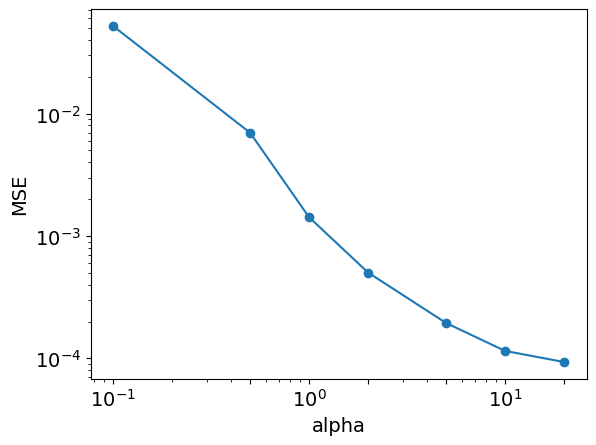

In [49]:
plt.figure()
plt.plot(test_scalar, target_mse, marker='o')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.yscale('log')
plt.xscale('log')
plt.xticks(test_scalar)
plt.show()

In [50]:
print(target_mse)

[0.05188463, 0.0069781523, 0.001424668, 0.0005034091, 0.00019495252, 0.00011532133, 9.352231e-05]


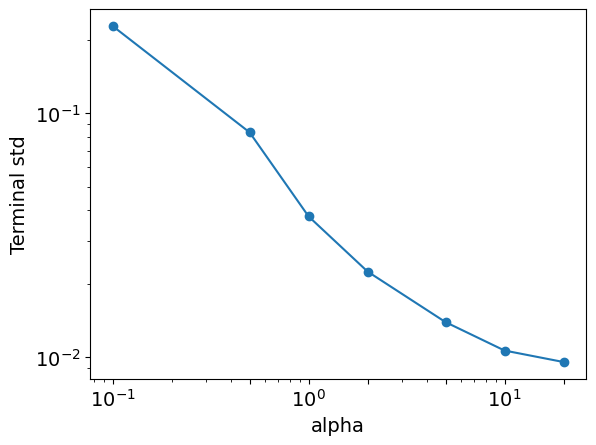

In [33]:
plt.figure()
plt.plot(test_scalar, terminal_std, marker='o')
plt.xlabel('alpha')
plt.ylabel('Terminal std')
plt.xscale('log')
plt.yscale('log')
plt.xticks(test_scalar)
plt.show()

In [34]:
print(terminal_std)

[0.22764519, 0.08342366, 0.03773141, 0.022424702, 0.013913138, 0.010640567, 0.009548055]


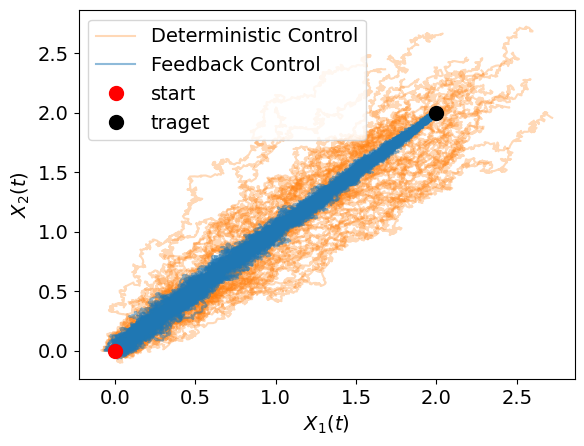

In [51]:
plt.figure()
for i in range(50):
    if i == 0:
        # plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy(), color='C0', alpha=0.5, label='Feedback Control')
        plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy(), color='C1', alpha=0.3, label='Deterministic Control')
    else:
        # plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy(), color='C0', alpha=0.3)
        plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy(), color='C1', alpha=0.3)
# obs.plot(ax=plt.gca())
for i in range(50):
    if i == 0:
        plt.plot(X_test[-1,:,i,0].detach().numpy(), X_test[-1,:,i,1].detach().numpy(), color='C0', alpha=0.5, label='Feedback Control')
    else:
        plt.plot(X_test[-1,:,i,0].detach().numpy(), X_test[-1,:,i,1].detach().numpy(), color='C0', alpha=0.5)
plt.plot(x_0[0], x_0[1], color='r', marker='o', markersize=10, label='start', ls='None')
plt.plot(y[0], y[1], color='black', marker='o', markersize=10, label='traget', ls='None')
plt.xlabel(r'$X_1(t)$')
plt.ylabel(r'$X_2(t)$')
plt.legend()
# plt.title('Avoid Obstacle')
# plt.show()
# plt.savefig('avoid_obstacle.pdf')


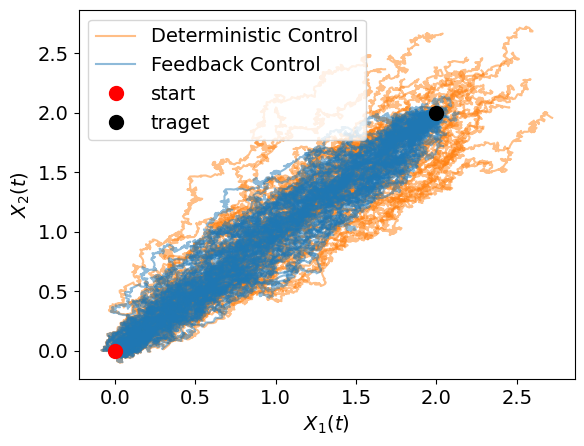

In [36]:
plt.figure()
for i in range(50):
    if i == 0:
        # plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy(), color='C0', alpha=0.5, label='Feedback Control')
        plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy(), color='C1', alpha=0.5, label='Deterministic Control')
    else:
        # plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy(), color='C0', alpha=0.3)
        plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy(), color='C1', alpha=0.5)
# obs.plot(ax=plt.gca())
for i in range(50):
    if i == 0:
        plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy(), color='C0', alpha=0.5, label='Feedback Control')
    else:
        plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy(), color='C0', alpha=0.5)
plt.plot(x_0[0], x_0[1], color='r', marker='o', markersize=10, label='start', ls='None')
plt.plot(y[0], y[1], color='black', marker='o', markersize=10, label='traget', ls='None')
plt.xlabel(r'$X_1(t)$')
plt.ylabel(r'$X_2(t)$')
plt.legend()
# plt.title('Avoid Obstacle')
# plt.show()
plt.savefig('Brownian_Bridge.pdf')



In [37]:
print(X_pred[-1,:,:].detach().mean(dim=0)-y.T)

tensor([[-0.0005,  0.0004]])


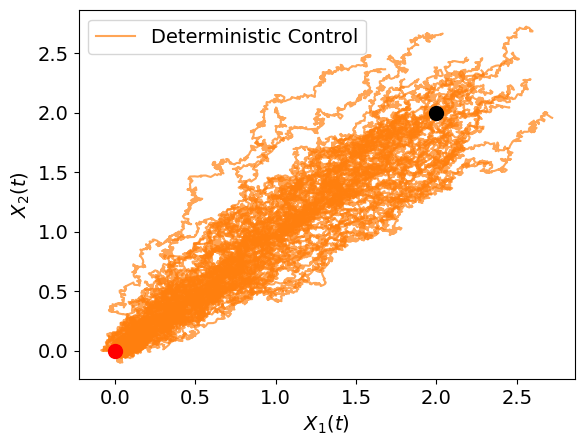

In [38]:
plt.figure()
for i in range(50):
    if i == 0:
        # plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy(), color='C0', alpha=0.5, label='Feedback Control')
        plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy(), color='C1', alpha=0.7, label='Deterministic Control')
    else:
        # plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy(), color='C0', alpha=0.3)
        plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy(), color='C1', alpha=0.7)
plt.plot(x_0[0], x_0[1], color='r', marker='o', markersize=10)
plt.plot(y[0], y[1], color='black', marker='o', markersize=10)
plt.xlabel(r'$X_1(t)$')
plt.ylabel(r'$X_2(t)$')
plt.legend()
plt.show()

In [39]:
# X_elimited = elitraj(X_pred2.detach(), obs)

In [40]:
# X_elimited.shape

In [41]:
# traj_num = X_elimited.shape[1]

In [42]:
# plt.figure()
# for i in range(335):
#     plt.plot(X_elimited[:,i,0], X_elimited[:,i,1])
# obs.plot(ax=plt.gca())
# plt.show()

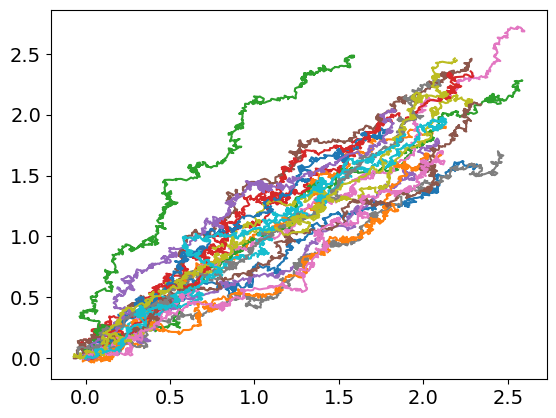

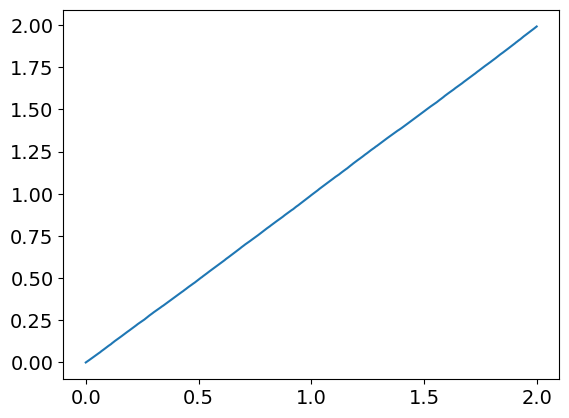

In [43]:
plt.figure()
for i in range(20):
    plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy())
# obs.plot(ax=plt.gca())
plt.show()

plt.figure()
plt.plot(X_pred2[:,:,0].mean(axis=1).detach().numpy(), X_pred2[:,:,1].mean(axis=1).detach().numpy())
plt.show()

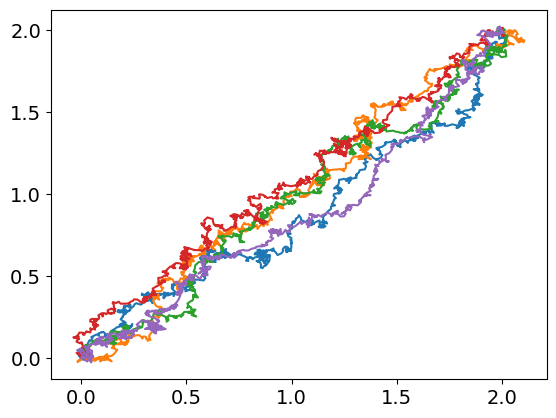

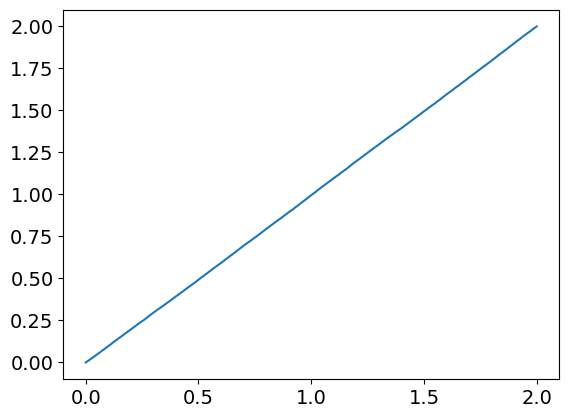

In [44]:
plt.figure()
for i in range(5):
    plt.plot(X_pred3[:,i,0].detach().numpy(), X_pred3[:,i,1].detach().numpy())
plt.show()

plt.figure()
plt.plot(X_pred3[:,:,0].mean(axis=1).detach().numpy(), X_pred3[:,:,1].mean(axis=1).detach().numpy())
plt.show()

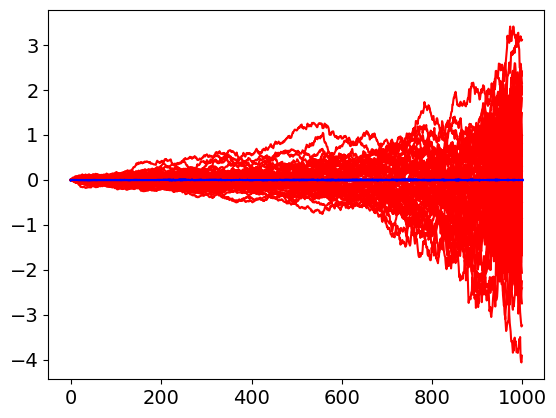

In [45]:
plt.figure()
for i in range(50):
    plt.plot(k_record[:,i,0].detach().numpy(), color='r')
    plt.plot(u_s_record[:,i,0].detach().numpy(), color='b')
plt.show()

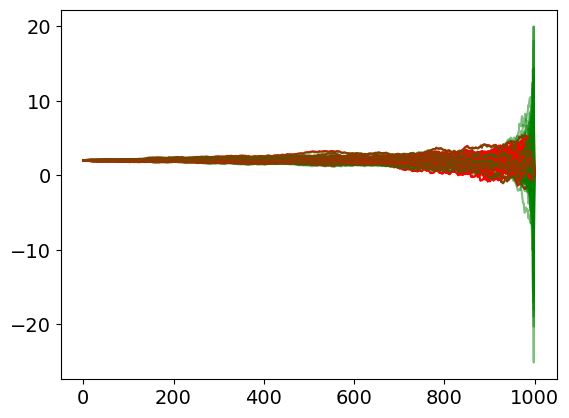

In [46]:
plt.figure()
for i in range(50):
    plt.plot(u1_record[:,i,0].detach().numpy(), color='r')
    # plt.plot(u2_record[:99,i,0].detach().numpy(), color='b')
    plt.plot(u3_record[:,i,0].detach().numpy(), color='g', alpha=0.5)
plt.show()